In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [70]:
pd.set_option('display.width', 220)
pd.set_option('display.max_colwidth', 30)

# ***Homework part 1***

# ***Orders dataset***

In this section I will check:

* Distribution of hours at which clients create orders

* The evolution of orders in the date available

* The distribution of the number of products per order

* Unique clients vs recurrent clients

* Find the most bought items (and relate the variant_id with the product_name, price, etc( inventory data))

* Make a market basket analysis to discover products bought together

In [71]:
orders_path = '/home/alex/zriveAM/zrive-ds/aws/data/orders.parquet'
orders_df = pd.read_parquet(orders_path)
orders_df.head(5)

,id,user_id,created_at,order_date,user_order_seq,ordered_items
10,2204073066628,62e271062eb827e411bd739411...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 336188601..."
20,2204707520644,bf591c887c46d5d3513142b6a8...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 336188359..."
21,2204838822020,329f08c66abb51f8c0b8a95266...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 336188935..."
34,2208967852164,f6451fce7b1c58d0effbe37fcb...,2020-05-01 19:44:11,2020-05-01,1,"[33618830196868, 336188465..."
49,2215889436804,68e872ff888303bff58ec56a3a...,2020-05-03 21:56:14,2020-05-03,1,"[33667166699652, 336671666..."


In [72]:
print("Orders info:")
print(orders_df.info())

Orders info:
<class 'pandas.core.frame.DataFrame'>
Index: 8773 entries, 10 to 64538
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8773 non-null   int64         
 1   user_id         8773 non-null   object        
 2   created_at      8773 non-null   datetime64[us]
 3   order_date      8773 non-null   datetime64[us]
 4   user_order_seq  8773 non-null   int64         
 5   ordered_items   8773 non-null   object        
dtypes: datetime64[us](2), int64(2), object(2)
memory usage: 479.8+ KB
None


               id                        user_id          created_at order_date  user_order_seq                  ordered_items  created_at_hour
10  2204073066628  62e271062eb827e411bd739411... 2020-04-30 14:32:19 2020-04-30               1  [33618849693828, 336188601...               14
20  2204707520644  bf591c887c46d5d3513142b6a8... 2020-04-30 17:39:00 2020-04-30               1  [33618835243140, 336188359...               17
21  2204838822020  329f08c66abb51f8c0b8a95266... 2020-04-30 18:12:30 2020-04-30               1  [33618891145348, 336188935...               18
34  2208967852164  f6451fce7b1c58d0effbe37fcb... 2020-05-01 19:44:11 2020-05-01               1  [33618830196868, 336188465...               19
49  2215889436804  68e872ff888303bff58ec56a3a... 2020-05-03 21:56:14 2020-05-03               1  [33667166699652, 336671666...               21


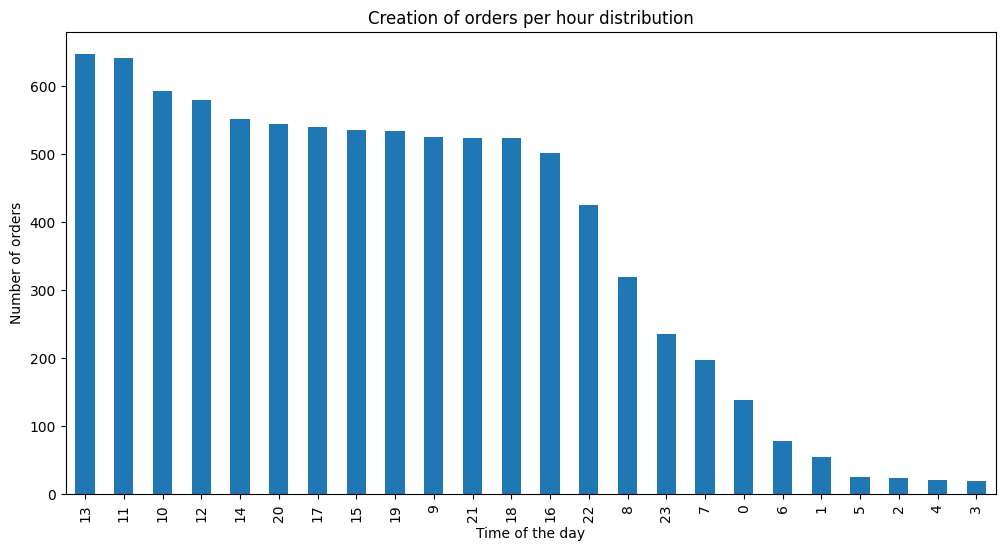

In [73]:
#column with the hour of creation of the order
orders_df['created_at_hour']=orders_df['created_at'].dt.hour
print(orders_df.head())

orders_per_hour=orders_df['created_at_hour'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12,6))
orders_per_hour.plot(kind='bar')
plt.title('Creation of orders per hour distribution')
plt.xlabel('Time of the day')
plt.ylabel('Number of orders')
plt.show()



We can push notifications at these hours to maximize creating orders

Orders evolution


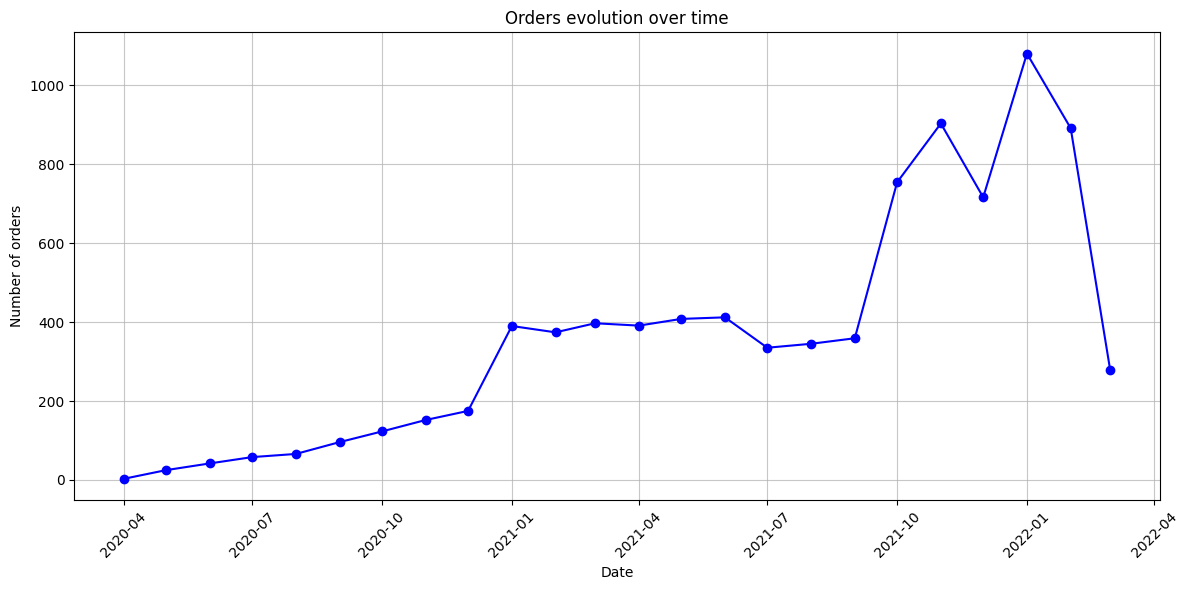

In [74]:
#evolution of orders in the last years

print("Orders evolution")

orders_by_month = orders_df.groupby(orders_df['order_date'].dt.to_period('M')).size()
orders_by_month.index = orders_by_month.index.to_timestamp()

plt.figure(figsize=(12,6))
plt.plot(orders_by_month.index, orders_by_month.values, marker='o', linestyle='-', color='b')
plt.title('Orders evolution over time')
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.grid(True, alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [75]:
#Let's create a new column with the nbumber of items per order
orders_df['items_per_order'] = orders_df['ordered_items'].apply(len)
orders_df=orders_df[['id','user_id','created_at', 'created_at_hour','order_date','user_order_seq','ordered_items','items_per_order']]
orders_df.head()

,id,user_id,created_at,created_at_hour,order_date,user_order_seq,ordered_items,items_per_order
10,2204073066628,62e271062eb827e411bd739411...,2020-04-30 14:32:19,14,2020-04-30,1,"[33618849693828, 336188601...",14
20,2204707520644,bf591c887c46d5d3513142b6a8...,2020-04-30 17:39:00,17,2020-04-30,1,"[33618835243140, 336188359...",25
21,2204838822020,329f08c66abb51f8c0b8a95266...,2020-04-30 18:12:30,18,2020-04-30,1,"[33618891145348, 336188935...",15
34,2208967852164,f6451fce7b1c58d0effbe37fcb...,2020-05-01 19:44:11,19,2020-05-01,1,"[33618830196868, 336188465...",10
49,2215889436804,68e872ff888303bff58ec56a3a...,2020-05-03 21:56:14,21,2020-05-03,1,"[33667166699652, 336671666...",10


count    8773.000000
mean       12.305711
std         6.839507
min         1.000000
25%         8.000000
50%        11.000000
75%        15.000000
max       114.000000
Name: items_per_order, dtype: float64


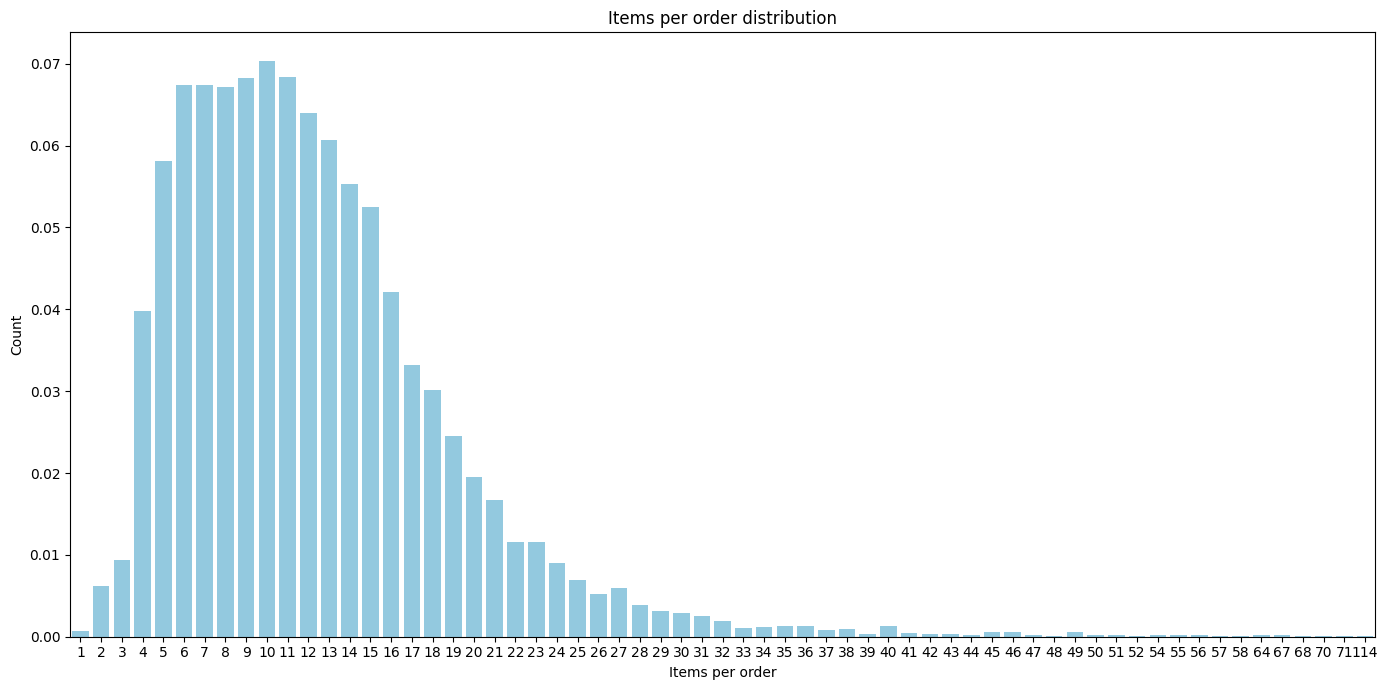

In [76]:
#items_per_order distribution
print(orders_df['items_per_order'].describe())

item_counts = orders_df['items_per_order'].value_counts().sort_index()

item_counts_normalized = item_counts / item_counts.sum()

plt.figure(figsize=(14, 7))
sns.barplot(x= item_counts_normalized.index, y= item_counts_normalized.values, color='skyblue')
#item_counts_normalized.plot(kind='bar', color='skyblue')
plt.title('Items per order distribution')
plt.xlabel('Items per order')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(False)
plt.tight_layout()
plt.show()

In [77]:
#Unique clients
unique_clients=orders_df['user_id'].value_counts()
unique_clients

user_id
ba7176c5f870cd86e51ecc4375e0becc8cc305845e70b9384ba0d4d156c6099ec96602b15420cb1ff69b6b9adcf9249d09489d511565531c4e928a92157b16d6    25
114e78a8909ad3f9d481e66563998301eff9e7cd1b2d002b77ffc26619f0ef7a6e877d5b3460e0e0bde2d7c67787c66d7384ccf34b4aa4fa1409e978cf47e670    22
04e9d7967f4dfd7d40175f130f1c80f62204ff697df92dfd83407ace7997b6744b6a7cab0382e60f7264b13ba3f03c64f016ae9dca664885ace6020aba3b5131    22
1296e1e72f7f43ff28d7d285f880ad4d213fa8139233c78ad2673af4cc0c1c297180254da494cc3b934858347822be437eeb072acb1403e9476dc0b2f6a83cbe    21
a655b992a3ee5f6aa9f5ab5662c4befac1fdc45c99885b173618b661ca7381c383b1364e977c9f51366cdc62e4d92ff383e8e5aac7ea9a552059be2671de24e2    21
                                                                                                                                    ..
720193c88605b61f880b340ca9a02c673241a37ff74f7d20639fc933ed5438a3b96076b85f168231d34779994c26810adbb24e0d842639837780649a4baf16a8     1
76f2a192182b2d88816355ac40307d4323c6d62da2a27d9

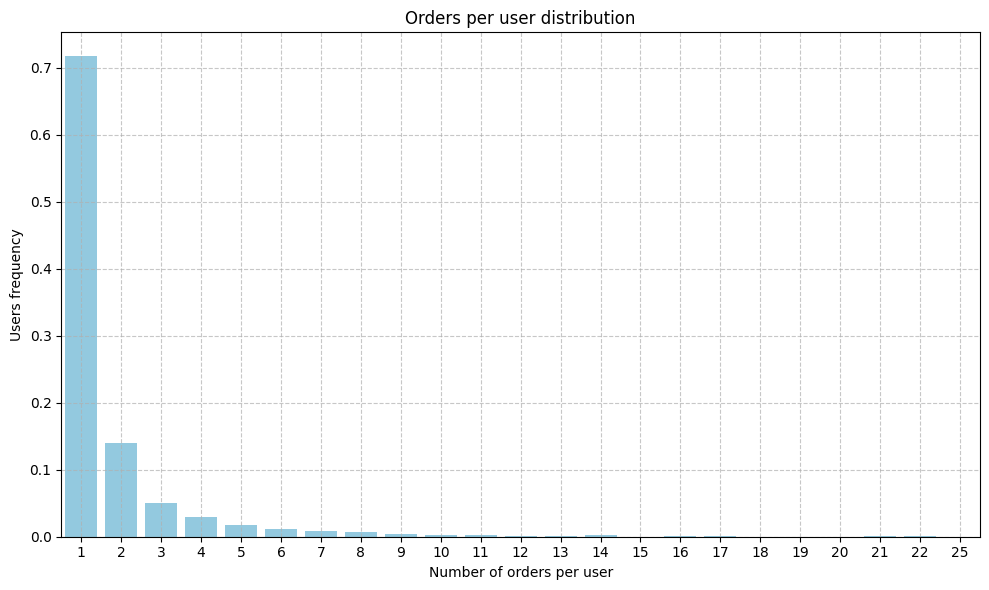

In [78]:
plt.figure(figsize=(10, 6))
value_counts_unique_clients=unique_clients.value_counts().sort_index()

value_counts_unique_clients_normalized = value_counts_unique_clients / value_counts_unique_clients.sum()
sns.barplot(x=value_counts_unique_clients_normalized.index, y=value_counts_unique_clients_normalized.values, color='skyblue')

plt.title('Orders per user distribution')
plt.xlabel('Number of orders per user')
plt.ylabel('Users frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Users with 1 order: 3572
Users with more than 1 order: 1411


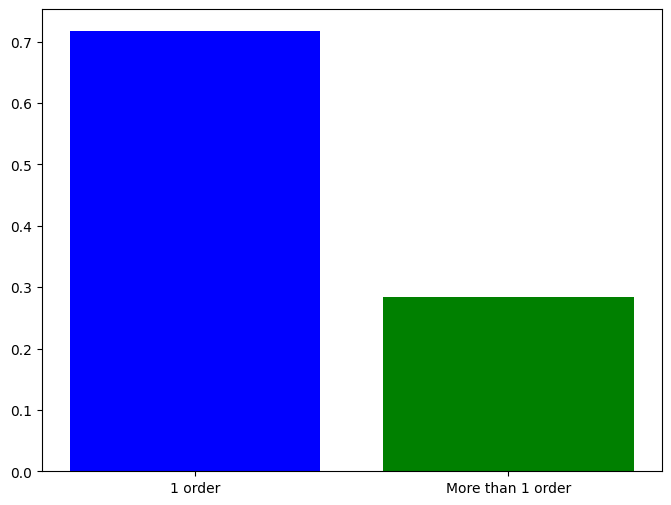

Clients that repeated buying in our platform: 28.316275336142887 %


In [79]:
num_users_with_1_order = (unique_clients == 1).sum()
print(f'Users with 1 order: {num_users_with_1_order}')
num_users_with_more_than_1_order = (unique_clients > 1).sum()
print(f"Users with more than 1 order: {num_users_with_more_than_1_order}")
categories= ['1 order', 'More than 1 order']
counts=[num_users_with_1_order, num_users_with_more_than_1_order]
total=sum(counts)
normalized= [count / total for count in counts]

plt.figure(figsize=(8,6))
plt.bar(categories, normalized, color=['blue', 'green'])
plt.tight_layout
plt.show()

percentage_clients_repeat= num_users_with_more_than_1_order / (num_users_with_more_than_1_order + num_users_with_1_order)
print(f"Clients that repeated buying in our platform: {percentage_clients_repeat*100} %")

In [80]:
#Lets' examine the items in the orders
all_products = [product for sublist in orders_df['ordered_items'] for product in sublist]
print(type(all_products))

product_series = pd.Series(all_products)
print(product_series.dtype)
product_counts = product_series.value_counts().reset_index()
product_counts.columns = ['variant_id', 'Frequency']
product_counts = product_counts.sort_values(by='Frequency', ascending=False)
print(product_counts.head())

<class 'list'>
int64
       variant_id  Frequency
0  34081589887108       4487
1  39284117930116       2658
2  34137590366340       1459
3  34081331970180       1170
4  34284951863428       1133


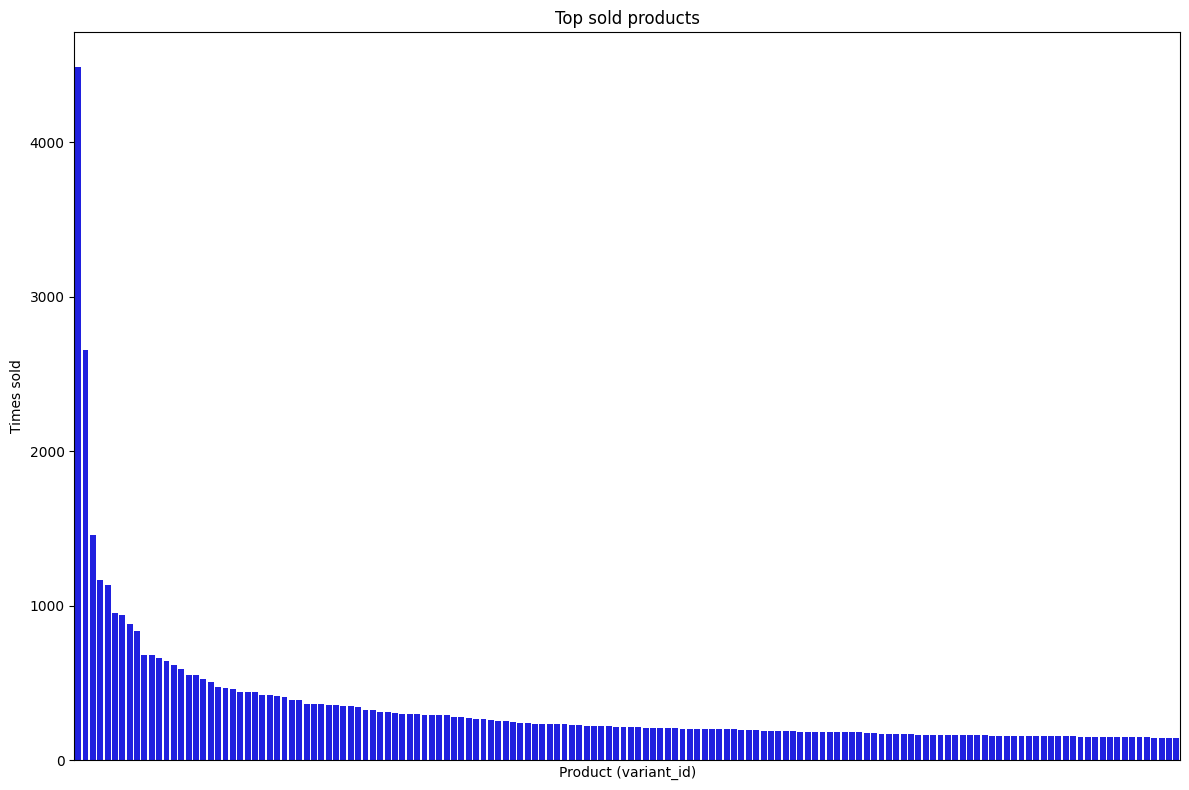

In [81]:
top_products = product_counts.head(150)

plt.figure(figsize=(12, 8))
sns.barplot(x='variant_id', y='Frequency',data=top_products,legend=False,color='blue',order=top_products['variant_id'])


plt.title('Top sold products')
plt.xlabel('Product (variant_id)')
plt.ylabel('Times sold')
plt.xticks([])
plt.tight_layout()
plt.show()

In [82]:
#join products counts with inventory data
inventory_path = '/home/alex/zriveAM/zrive-ds/aws/data/inventory.parquet'
inventory_df = pd.read_parquet(inventory_path)
print(inventory_df.shape)
inventory_df.head()

(1733, 6)


,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-t...,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-t...,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-t...,"[b-corp, cruelty-free, eco..."
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


In the inventory df we have 1733 variant_ids (products), while in product counts we have 2117 variant_ids. It suggests that some products have been removed from stock and are no longer available

In [83]:
#Complete product_counts dataframe with information from inventory
combined_df = pd.merge(product_counts,inventory_df,on='variant_id',how='left')

print(combined_df.head())
print(combined_df.shape)
print('------------------------------------')
print('Delete rows with null values')
print('------------------------------------')
combined_df_cleaned=combined_df.dropna()
print(combined_df_cleaned.head())
print(combined_df_cleaned.shape)



       variant_id  Frequency  price  compare_at_price  vendor                   product_type               tags
0  34081589887108       4487  10.79             11.94   oatly     long-life-milk-substitutes  [oat-milk, vegan]
1  39284117930116       2658    NaN               NaN     NaN                            NaN                NaN
2  34137590366340       1459    NaN               NaN     NaN                            NaN                NaN
3  34081331970180       1170    NaN               NaN     NaN                            NaN                NaN
4  34284951863428       1133   3.69              3.99  plenty  toilet-roll-kitchen-roll-t...     [kitchen-roll]
(2117, 7)
------------------------------------
Delete rows with null values
------------------------------------
       variant_id  Frequency  price  compare_at_price         vendor                   product_type                           tags
0  34081589887108       4487  10.79             11.94          oatly     long-life-m

Althought we have 1733 variant_ids in the inventory, some have null values, that's the reason of having 1477 rows after the cleaning instead of 1733 (supposedly we would go from 2117 --> 1733, but we went from 2117 --> 1477).

At this point we should guess why there are missing variant_ids, it's probably that it's because this items are no longer available, but we should confirm this hypothesis

In [84]:
null_rows_df = combined_df[combined_df.isnull().any(axis=1)]
null_rows_df.head()

,variant_id,Frequency,price,compare_at_price,vendor,product_type,tags
1,39284117930116,2658,NaN,NaN,NaN,NaN,NaN
2,34137590366340,1459,NaN,NaN,NaN,NaN,NaN
3,34081331970180,1170,NaN,NaN,NaN,NaN,NaN
42,39711187894404,315,NaN,NaN,NaN,NaN,NaN
48,39478260662404,293,NaN,NaN,NaN,NaN,NaN


In [85]:
#use orders_df and null_rows_df to discover the date of the null items
null_variants_id=null_rows_df['variant_id'].tolist()
print(null_variants_id)
print('-----------------------')


def count_null_items(ordered_items):
    return sum(item in null_variants_id for item in ordered_items)


orders_df['null_items_count'] = orders_df['ordered_items'].apply(count_null_items)
orders_df['ratio_null_items'] = orders_df['null_items_count'] / orders_df['items_per_order']


print(orders_df[['id', 'order_date', 'ordered_items', 'items_per_order', 'null_items_count', 'ratio_null_items']].head())

[39284117930116, 34137590366340, 34081331970180, 39711187894404, 39478260662404, 33977921208452, 39459281404036, 39462593233028, 39511041605764, 34370917204100, 33667283648644, 34436055269508, 39459282059396, 33977922650244, 33826477834372, 34519123820676, 33667263627396, 34081589624964, 34502822396036, 39459279437956, 34436055171204, 33667216441476, 34304124420228, 34457368199300, 39459280912516, 34276571316356, 33667174695044, 39368665825412, 34284953763972, 39459280224388, 33667232891012, 34304124387460, 39459280027780, 33667214180484, 33826457059460, 39711187861636, 34276569219204, 33667305373828, 39459280126084, 33826427240580, 34276570562692, 33826423406724, 33667232661636, 33826478555268, 33826467446916, 39711187927172, 34317850673284, 33826459844740, 34317851984004, 33667226173572, 34535159398532, 34221708312708, 34370914320516, 33973242429572, 33667241083012, 34081589690500, 34368925237380, 39459279732868, 33826454667396, 34535159595140, 33826414329988, 34317851525252, 3382641

In [86]:
#how count_null_items function works
my_list=[1,2,3,4,5]

values=[1,4]

sum(item in my_list for item in values )

2

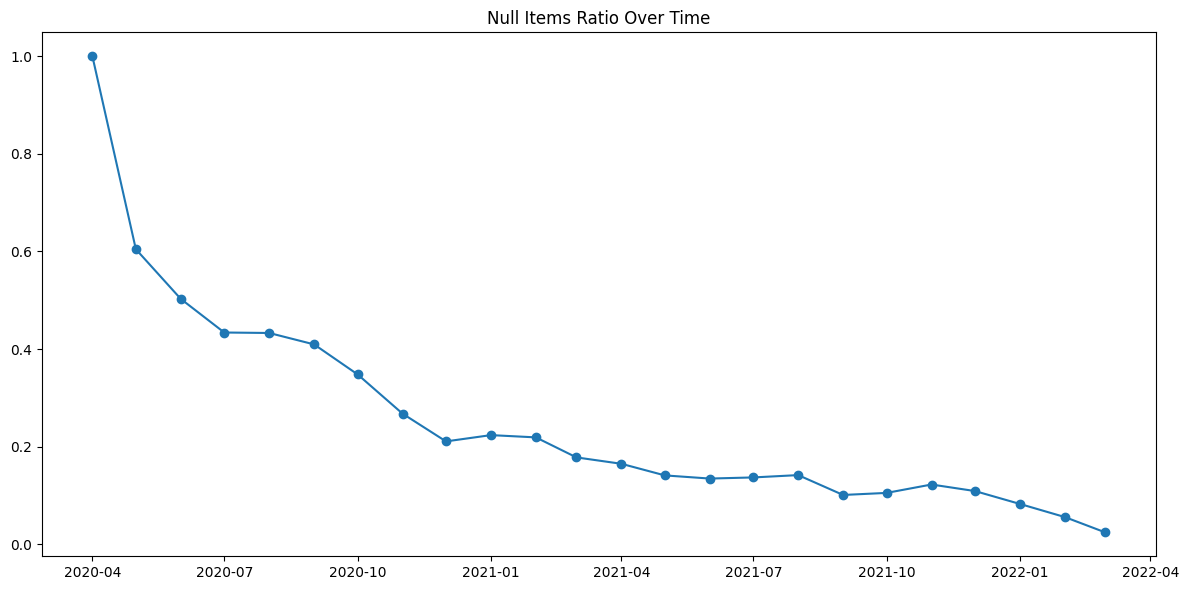

In [87]:
orders_df['order_date_month']= orders_df['order_date'].dt.to_period('M')

monthly_summary = orders_df.groupby('order_date_month').agg(
    items_per_order_month=('items_per_order', 'sum'),
    null_items_count_month=('null_items_count', 'sum')
).reset_index()

monthly_summary['missing_ratio_month'] = (
    monthly_summary['null_items_count_month'] / monthly_summary['items_per_order_month']
)

monthly_summary['order_date_month'] = monthly_summary['order_date_month'].dt.to_timestamp()
monthly_summary.head()

plt.figure(figsize=(12,6))
plt.plot(monthly_summary['order_date_month'], monthly_summary['missing_ratio_month'], marker='o', label='Null Items Count')
plt.title('Null Items Ratio Over Time')
plt.tight_layout()
plt.show()


It's clear that the null items (non existing variant_ids in our inventory) are products that are no longer available

In [88]:
#let's try a market basket analysis to discover products bought together
from mlxtend.preprocessing import TransactionEncoder

transactions= orders_df['ordered_items'].tolist()
te=TransactionEncoder()
te_ary=te.fit(transactions).transform(transactions)

orders_df_encoded=pd.DataFrame(te_ary, columns=te.columns_)
#print(orders_df_encoded)

from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(orders_df_encoded, min_support=0.02, use_colnames=True)
print(frequent_itemsets.head())
print('--------------------------------------')

from mlxtend.frequent_patterns import association_rules
num_itemsets = len(frequent_itemsets)
rules= association_rules(frequent_itemsets, metric='lift', min_threshold=1.0, num_itemsets=num_itemsets)
print(rules)
print('--------------------------------------')
filtered_rules = rules[['antecedents','consequents','support','confidence','lift']].copy()
variant_id_to_product_type= inventory_df.set_index('variant_id')['product_type'].to_dict()
def replace_variant_with_product_type(itemset, mapping):
    return frozenset({mapping.get(int(item), item) for item in itemset})

filtered_rules['antecedents'] = filtered_rules['antecedents'].apply(lambda x: replace_variant_with_product_type(x, variant_id_to_product_type))
filtered_rules['consequents'] = filtered_rules['consequents'].apply(lambda x: replace_variant_with_product_type(x, variant_id_to_product_type))
print(filtered_rules)

    support          itemsets
0  0.023823  (33667185279108)
1  0.025647  (33667206283396)
2  0.047874  (33667207266436)
3  0.035564  (33667222798468)
4  0.020062  (33667247276164)
--------------------------------------
        antecedents       consequents  antecedent support  consequent support   support  confidence      lift  representativity  leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski
0  (34284949766276)  (39284117930116)            0.070329            0.302975  0.024507    0.348460  1.150129               1.0  0.003199    1.069812       0.140407  0.070261   0.065256    0.214674
1  (39284117930116)  (34284949766276)            0.302975            0.070329  0.024507    0.080888  1.150129               1.0  0.003199    1.011488       0.187270  0.070261   0.011357    0.214674
2  (39284117930116)  (34284950356100)            0.302975            0.063946  0.029180    0.096313  1.506157               1.0  0.009806    1.035816       0.482133  0.086399   0.034578  

In this case, the Rule 0 says that if someone buy product 34284949766276, there is a 34.85% probability to also buy 39284117930116.

This analysis is not very relevant; all the pairs of related products have a missing product and it doesn't bring information at the present time

### Insights

* Most orders have between 8 and 15 items (average of 12), but there are outliers of up to 114 items, suggesting opportunities to serve wholesale customers or drive larger purchases with strategic promotions.

* 28.3 % of our clients repeated buying in our platform.

* Some products (variant_id) appear in the orders but not in the inventory, these are products that were available at some point, but not currently.

### Problems & comments

* Variant_ids shown in orders dataset not registered in the inventory.

* We could also extract some informationfrom the order_date column combined with users that repeated buying to discover how often they buy.

# ***Regulars dataset***

* Include info about each variant_id

* Find popular regular items

* Find users that added more regular items (we can identify the most interested and active clients)

In [89]:
regulars_path = '/home/alex/zriveAM/zrive-ds/aws/data/regulars.parquet'
regulars_df = pd.read_parquet(regulars_path)
regulars_df.head()

,user_id,variant_id,created_at
3,68e872ff888303bff58ec56a3a...,33618848088196,2020-04-30 15:07:03
11,aed88fc0b004270a62ff1fe4b9...,33667178659972,2020-05-05 23:34:35
18,68e872ff888303bff58ec56a3a...,33619009208452,2020-04-30 15:07:03
46,aed88fc0b004270a62ff1fe4b9...,33667305373828,2020-05-05 23:34:35
47,4594e99557113d5a1c5b59bf31...,33667247341700,2020-05-06 14:42:11


In [90]:
print("Dataframe info:")
print(regulars_df.info())

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
Index: 18105 entries, 3 to 37720
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18105 non-null  object        
 1   variant_id  18105 non-null  int64         
 2   created_at  18105 non-null  datetime64[us]
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 565.8+ KB
None


In [91]:
#use dictionary to include product_name of variant_id
regulars_combined_df = pd.merge(regulars_df,inventory_df,on='variant_id',how='left')
regulars_combined_df.head()

,user_id,variant_id,created_at,price,compare_at_price,vendor,product_type,tags
0,68e872ff888303bff58ec56a3a...,33618848088196,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN
1,aed88fc0b004270a62ff1fe4b9...,33667178659972,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN
2,68e872ff888303bff58ec56a3a...,33619009208452,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN
3,aed88fc0b004270a62ff1fe4b9...,33667305373828,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN
4,4594e99557113d5a1c5b59bf31...,33667247341700,2020-05-06 14:42:11,3.49,3.5,method,cleaning-products,"[cruelty-free, eco, vegan,..."


As in the previous case, there are products that are no longer available, the best option is get rid of them

In [92]:
regulars_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18105 entries, 0 to 18104
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           18105 non-null  object        
 1   variant_id        18105 non-null  int64         
 2   created_at        18105 non-null  datetime64[us]
 3   price             15034 non-null  float64       
 4   compare_at_price  15034 non-null  float64       
 5   vendor            15034 non-null  object        
 6   product_type      15034 non-null  object        
 7   tags              15034 non-null  object        
dtypes: datetime64[us](1), float64(2), int64(1), object(4)
memory usage: 1.1+ MB


In [93]:
cleaned_regulars_combined_df=regulars_combined_df.dropna()
cleaned_regulars_combined_df.head()

,user_id,variant_id,created_at,price,compare_at_price,vendor,product_type,tags
4,4594e99557113d5a1c5b59bf31...,33667247341700,2020-05-06 14:42:11,3.49,3.50,method,cleaning-products,"[cruelty-free, eco, vegan,..."
8,4594e99557113d5a1c5b59bf31...,33667182493828,2020-05-06 14:42:11,4.29,5.40,bulldog,skincare,"[cruelty-free, eco, facial..."
17,d883991facbc3b07b62da342d0...,33667198910596,2020-07-06 10:12:08,14.99,16.55,ecover,dishwashing,"[cruelty-free, dishwasher-..."
18,66a195720d6988ff4d32155cc0...,33826459320452,2020-07-06 17:17:52,5.09,5.65,treeoflife,snacks-confectionery,"[christmas, nuts-dried-fru..."
19,0b7e02fee4b9e215da3bdae700...,33667247276164,2020-07-18 16:56:55,2.49,3.00,method,hand-soap-sanitisers,"[cruelty-free, eco, hand-s..."


In [94]:
len(regulars_combined_df['variant_id'].value_counts())

1843

In [95]:
len(cleaned_regulars_combined_df['variant_id'].value_counts())

1285

From the initial 1843 products in the regulars section, 558 are no longer available

In [96]:
#find the product (variant_id) more requested
requested_products = cleaned_regulars_combined_df['variant_id'].value_counts().reset_index()
requested_products.columns=['variant_id', 'request_count']
requested_products= pd.merge(requested_products, inventory_df, on='variant_id', how='left')
requested_products.head()

,variant_id,request_count,price,compare_at_price,vendor,product_type,tags
0,34081589887108,253,10.79,11.94,oatly,long-life-milk-substitutes,"[oat-milk, vegan]"
1,34370361229444,127,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-t...,"[b-corp, eco, toilet-rolls]"
2,34370915041412,112,4.99,6.60,mutti,tins-packaged-foods,"[pasta-pizza-sauce, tinned..."
3,34284951863428,105,3.69,3.99,plenty,toilet-roll-kitchen-roll-t...,[kitchen-roll]
4,33667282436228,101,3.99,4.00,thecheekypanda,toilet-roll-kitchen-roll-t...,"[b-corp, cruelty-free, eco..."


In [97]:
#users that specified more items
users_activity= cleaned_regulars_combined_df['user_id'].value_counts().reset_index()
users_activity.columns=['user_id', 'number_of_regular_products']
users_activity.head()

,user_id,number_of_regular_products
0,a124c8bb0453ea0957405b7a08...,701
1,ba068a3398230c10a98868ced1...,455
2,9b5b3679033da9e1f3a4def186...,393
3,257be7ae940425880bbb20bf16...,364
4,9a4b53affbe91ca5fd0c97f6d8...,359


In [98]:
#find repeated users-product combination
recurrent_purchases = cleaned_regulars_combined_df.groupby(['user_id', 'variant_id']).size().reset_index(name='added_to_regulars')
pd.set_option('display.max_colwidth', 150)
print(len(recurrent_purchases))
print(recurrent_purchases)
print(len(recurrent_purchases[recurrent_purchases['added_to_regulars'] == 1]))
print(len(recurrent_purchases[recurrent_purchases['added_to_regulars'] > 1]))


9837
                                                                                                                               user_id      variant_id  added_to_regulars
0     004b3e3cb9a9f5b0974ce4179db394057c72e7a82077bfe6a28af9e6306ebc51b0d8c5c8bd4c9b59ebb3237827df723745c1374d12ad2053e0131edc184df17d  33667274997892                  1
1     005743eefffa4ce840608c4f47b8c548b134d89be5c39020ea20c4e708544b2dbd94e4b662b34c7c8b2ba1557a54454e45a7349bd7c024d9f5def354d3f38c53  34081589887108                  1
2     005743eefffa4ce840608c4f47b8c548b134d89be5c39020ea20c4e708544b2dbd94e4b662b34c7c8b2ba1557a54454e45a7349bd7c024d9f5def354d3f38c53  34519123951748                  1
3     0074992079c1836c6509eec748a973dc97388b4877e770f57a3dc05917641897fd65ed9ab35168ce32f7c428c3e048206e12a653f40d48d7eb7db3570b4521b4  33667247243396                  1
4     0074992079c1836c6509eec748a973dc97388b4877e770f57a3dc05917641897fd65ed9ab35168ce32f7c428c3e048206e12a653f40d48d7eb7db3570b4521b4  336672895

According to the information above, there are some users (2098) that added the same product multiple times, this could give rise to confusion, because at the end it's only 1 product

In [99]:

user_id_filter = "fffd9f989509e36d1fc3e3e53627d6341482f385052a034a897249a5455c66475dfc78fc8eec13b742ada69537b20dc5b24cc59864ee21c50816f1131cf10527"
variant_id_filter = 39590266536068

filtered_rows = cleaned_regulars_combined_df[
    (cleaned_regulars_combined_df['user_id'] == user_id_filter) & 
    (cleaned_regulars_combined_df['variant_id'] == variant_id_filter)
]


print(filtered_rows)

                                                                                                                                user_id      variant_id          created_at  price  compare_at_price    vendor  \
1805   fffd9f989509e36d1fc3e3e53627d6341482f385052a034a897249a5455c66475dfc78fc8eec13b742ada69537b20dc5b24cc59864ee21c50816f1131cf10527  39590266536068 2022-01-20 09:27:43   2.49              2.59  bacofoil   
5786   fffd9f989509e36d1fc3e3e53627d6341482f385052a034a897249a5455c66475dfc78fc8eec13b742ada69537b20dc5b24cc59864ee21c50816f1131cf10527  39590266536068 2021-10-28 13:23:35   2.49              2.59  bacofoil   
11085  fffd9f989509e36d1fc3e3e53627d6341482f385052a034a897249a5455c66475dfc78fc8eec13b742ada69537b20dc5b24cc59864ee21c50816f1131cf10527  39590266536068 2022-02-04 10:56:52   2.49              2.59  bacofoil   
13165  fffd9f989509e36d1fc3e3e53627d6341482f385052a034a897249a5455c66475dfc78fc8eec13b742ada69537b20dc5b24cc59864ee21c50816f1131cf10527  39590266536068 2022-01-

## Insights

* long-life-milk-substitutes is the main product added to regulars, also the main product in orders, it's by far the most important product for us

# ***Abandoned_carts data***

* Find most frequent items in abandoned carts (and distribution)

* Find users with most abandoned_carts

* Find days with most abandoned_carts

In [100]:
abdandoned_carts_path = '/home/alex/zriveAM/zrive-ds/aws/data/abandoned_carts.parquet'
abandoned_carts_df = pd.read_parquet(abdandoned_carts_path)
abandoned_carts_df.head()

,id,user_id,created_at,variant_id
0,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b4130557c2e49c1193921975a2116d57fefbf911523ce44b6b6e0f8acbf598b36d0e4fc2727ec89378a,2020-05-20 13:53:24,"[33826459287684, 33826457616516, 33667192127620, 33826412331140, 33826472558724, 33826427240580, 33826474590340, 33826457157764, 33667198976132, 3..."
13,20352449839236,9d6187545c005d39e44d0456d87790db18611d7c7379bd2fb2c4c9ab335534542fecf99d201921dece1889ed054e5b5e8cd87a564815c04b07f6f53ee96861fc,2021-06-27 05:24:13,"[34415988179076, 34037940158596, 34502822363268, 33719435722884, 33803537973380, 39459279929476, 34284955304068, 34284952813700, 39542989619332]"
45,20478401413252,e83fb0273d70c37a2968fee107113698fd4f389c442c0b432bca5c2bad4fb803f6c24f90edb0dcb6e64d5791b9bfa389a738b7bad0f2cb19a5f6e4c4ae931009,2021-07-18 08:23:49,"[34543001337988, 34037939372164, 34113606090884, 34284952584324, 34221708673156, 39336624193668, 33667247145092, 39403031167108, 33951139135620, 3..."
50,20481783103620,10c42e10e530284b7c7c50f3a23a98726d5747b812808423874f43384ffdbfb574e3ccc11706aece4f1329b4365fe5bce1a01827d382852daedaf18a2e22fcb8,2021-07-18 21:29:36,"[33667268116612, 34037940224132, 34436055203972, 39403032117380, 33667207266436, 34284951273604, 34284951240836, 39403031691396, 39418337591428, 3..."
52,20485321687172,d9989439524b3f6fc4f41686d043f315fb408b954d6153a40c83cfa13aa8faebe1d7a2835a2e9c5120b806bc789704622081a413af5c418297da0516c892d756,2021-07-19 12:17:05,"[33667268083844, 34284950454404, 33973246886020]"


In [101]:
print("Dataframe info:")
print(abandoned_carts_df.info())

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
Index: 5457 entries, 0 to 70050
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          5457 non-null   int64         
 1   user_id     5457 non-null   object        
 2   created_at  5457 non-null   datetime64[us]
 3   variant_id  5457 non-null   object        
dtypes: datetime64[us](1), int64(1), object(2)
memory usage: 213.2+ KB
None


In [102]:
#most frequent items in abandoned_carts
all_abandoned_products = [product for sublist in abandoned_carts_df['variant_id'] for product in sublist]
print(type(all_abandoned_products))

abandoned_product_series = pd.Series(all_abandoned_products)
print(abandoned_product_series.dtype)
abandoned_product_counts = abandoned_product_series.value_counts().reset_index()
abandoned_product_counts.columns = ['variant_id', 'Frequency']
abandoned_product_counts = abandoned_product_counts.sort_values(by='Frequency', ascending=False)
print(abandoned_product_counts.head(15))

<class 'list'>
int64
        variant_id  Frequency
0   34081589887108        608
1   34284951863428        478
2   34284950356100        409
3   34137590366340        395
4   34284949766276        382
5   34284950519940        307
6   34284950454404        306
7   39459279929476        305
8   39284117930116        298
9   34037939372164        290
10  39709997760644        277
11  39405098369156        256
12  34370361229444        253
13  34543001370756        242
14  34543001337988        241


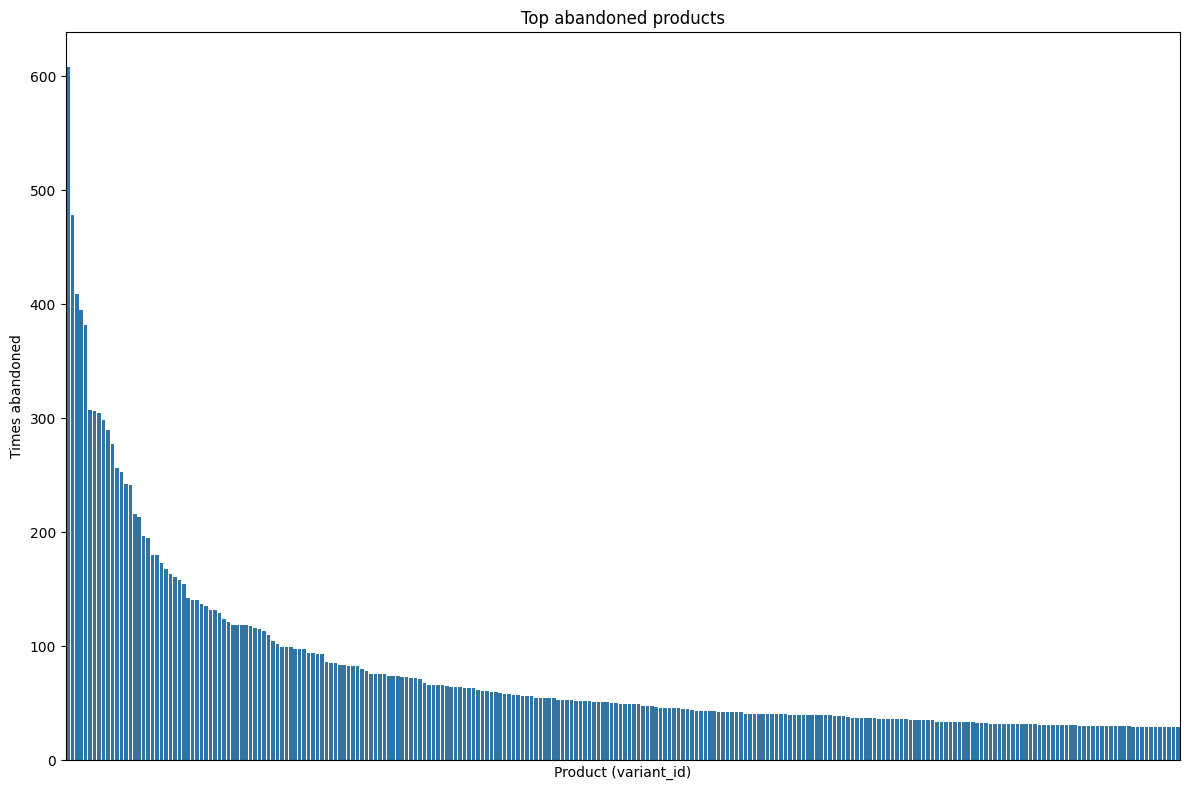

In [103]:
top_abandoned_products = abandoned_product_counts.head(250)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='variant_id', 
    y='Frequency', 
    data=top_abandoned_products, 
    order=top_abandoned_products['variant_id']
)


plt.title('Top abandoned products')
plt.xlabel('Product (variant_id)')
plt.ylabel('Times abandoned')
plt.xticks([])
plt.tight_layout()
plt.show()

In [104]:
#Complete abandoned_product_counts dataframe with information from inventory
combined_abandoned_df = pd.merge(abandoned_product_counts,inventory_df,on='variant_id',how='left')
combined_abandoned_df.head()

,variant_id,Frequency,price,compare_at_price,vendor,product_type,tags
0,34081589887108,608,10.79,11.94,oatly,long-life-milk-substitutes,"[oat-milk, vegan]"
1,34284951863428,478,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
2,34284950356100,409,1.99,3.00,fairy,dishwashing,"[discontinue, swapped, washing-up-liquid]"
3,34137590366340,395,NaN,NaN,NaN,NaN,NaN
4,34284949766276,382,8.49,9.00,andrex,toilet-roll-kitchen-roll-tissue,[toilet-rolls]


In [105]:
#users with most abandoned_carts
users_abandoned_carts = abandoned_carts_df['user_id'].value_counts().reset_index()
users_abandoned_carts.columns=['user_id', 'abandoned_carts_count']

users_path = '/home/alex/zriveAM/zrive-ds/aws/data/users.parquet'
users_df = pd.read_parquet(users_path)

combined_users_abandoned_carts = pd.merge(users_abandoned_carts,users_df,on='user_id',how='left')
combined_users_abandoned_carts.head()


,user_id,abandoned_carts_count,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
0,257be7ae940425880bbb20bf162c2616b32881bf0a8bda4e4ce7f5ce0356c29b06e032dd593030a460d20c71353737305e51431a7df58ea0284c67c95084a42b,10,Top Up,UKI,2021-06-10 15:00:55,2021-06-01 00:00:00,4.0,2.0,2.0,0.0,0.0
1,1dacfd2a360677052d8605f843ae410dd23b0ddb7f506cc447fa78ee26bb7182ea72a8107f16633ac611c1142e90dd47d4afec7f6374b8d7b1a29492d37dd51a,9,Proposition,UKG,2021-08-06 09:23:27,2021-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN
2,fffd9f989509e36d1fc3e3e53627d6341482f385052a034a897249a5455c66475dfc78fc8eec13b742ada69537b20dc5b24cc59864ee21c50816f1131cf10527,7,Top Up,UKF,2021-10-21 18:17:53,2021-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN
3,a8ea4d1ff9cfc5005b7354d1d17564347dd842bab2a6c39a52301046e9104a2819f65f03343f0e92a7a20cc8f1cc29d0fcf614a0f9601064b9fc684b0a908728,7,Top Up,UKF,2022-01-31 21:11:09,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4,97e81469f5758878f4d7eaa3af6b4fc37b2b5c2255881189c9bc6b4e7a2f2b63ac0c376b6116046cae8f6abc9a25f5eb28204a58c92f7e16635781cb216aa755,7,Proposition,UKK,2021-11-19 21:02:15,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


In [106]:
abandoned_carts_df_per_nuts=combined_users_abandoned_carts.groupby('user_nuts1')['abandoned_carts_count'].sum().reset_index()
abandoned_carts_df_per_nuts.sort_values(by='user_nuts1', inplace=True)
print(abandoned_carts_df_per_nuts)

   user_nuts1  abandoned_carts_count
0         UKC                    116
1         UKD                    371
2         UKE                    349
3         UKF                    298
4         UKG                    321
5         UKH                    457
6         UKI                   1451
7         UKJ                    772
8         UKK                    657
9         UKL                    257
10        UKM                    358


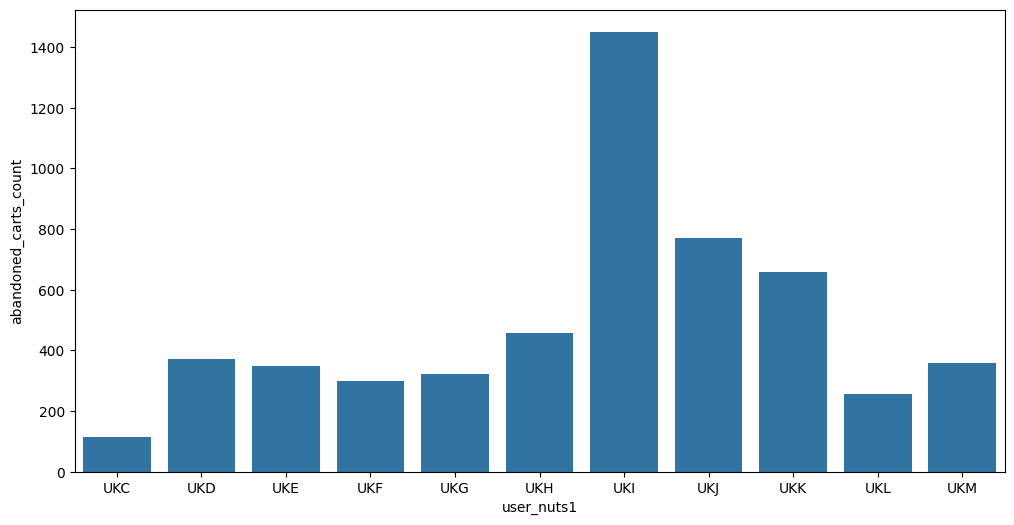

In [107]:
plt.figure(figsize=(12,6))
sns.barplot(x=abandoned_carts_df_per_nuts['user_nuts1'], y=abandoned_carts_df_per_nuts['abandoned_carts_count'])
plt.show()

This analysis would make more sense by calculating a ratio, as these results may be conditioned by the number of orders in each region.

In [108]:
orders_df = pd.read_parquet(orders_path)
orders_df.head(5)
users_df = pd.read_parquet(users_path)

orders_per_nuts= pd.merge(orders_df, users_df, on='user_id', how='left')
orders_per_nuts=orders_per_nuts[['id', 'user_nuts1']]
orders_per_nuts.head()

orders_per_nuts= orders_per_nuts.groupby('user_nuts1')['id'].count().reset_index()
orders_per_nuts.columns=['user_nuts1', 'orders_count']
print(orders_per_nuts.sort_values(by='user_nuts1', inplace=True))
print(orders_per_nuts)

None
   user_nuts1  orders_count
0         UKC           205
1         UKD           513
2         UKE           467
3         UKF           455
4         UKG           477
5         UKH           860
6         UKI          2177
7         UKJ          1427
8         UKK          1148
9         UKL           382
10        UKM           584
11        UKN             4


In [109]:
#calculate abandonments compared to num of orders for each region
ratio_abandonments_per_orders= abandoned_carts_df_per_nuts ['abandoned_carts_count'] / orders_per_nuts['orders_count']
ratio_abandonments_per_orders

0     0.565854
1     0.723197
2     0.747323
3     0.654945
4     0.672956
5     0.531395
6     0.666514
7     0.540995
8     0.572300
9     0.672775
10    0.613014
11         NaN
dtype: float64

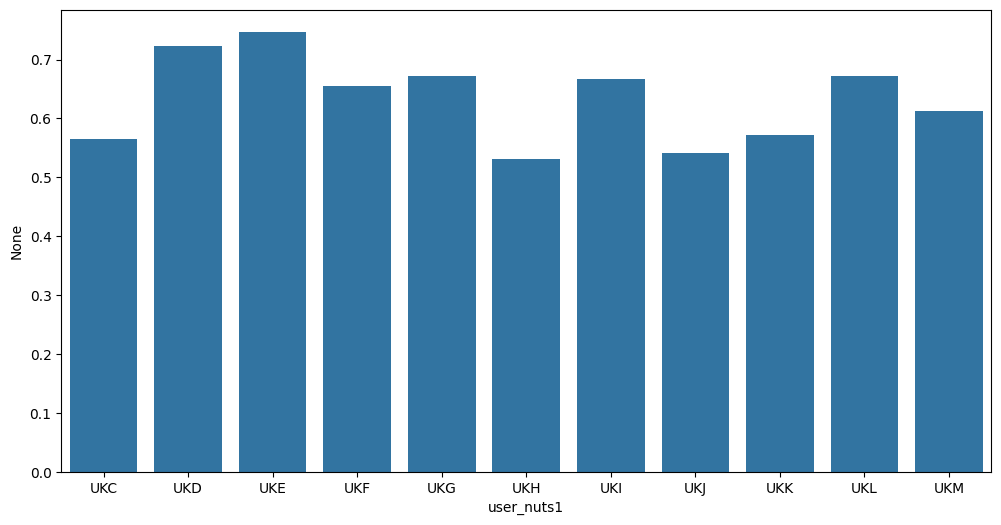

In [110]:
plt.figure(figsize=(12,6))
sns.barplot(x=abandoned_carts_df_per_nuts['user_nuts1'], y=ratio_abandonments_per_orders)
plt.show()

Indeed, the ratio is similar in all regions

### Insights

* Abandoned carts are related to orders, the best seller product long-life-milk-substitutes	is also the most abandoned product 

# ***Inventory data***

* Price and compare_at_price distribution

* Find products without price and without discount

* Top vendors

* Top product type

* Top tags

In [111]:
inventory_path = '/home/alex/zriveAM/zrive-ds/aws/data/inventory.parquet'
inventory_df = pd.read_parquet(inventory_path)
inventory_df.head(10)

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]
5,34460976447620,2.79,2.85,carex,hand-soap-sanitisers,"[hand-soap, refills]"
6,33667202121860,8.99,12.55,ecover,washing-liquid-gel,"[cruelty-free, eco, vegan, washing-liquid-gel]"
7,39478260695172,1.99,2.00,napolina,cooking-sauces,"[pasta-pizza-sauce, vegan]"
8,39772627533956,1.99,2.30,thepinkstuff,cleaning-products,"[all-purpose-cleaner, vegan]"
9,39887964766340,2.59,2.69,profusion,tins-packaged-foods,"[gluten-free, meat-alternatives, organic, vegan]"


In [112]:
print("Dataframe info:")
print(inventory_df.info())
print("----------------------------------")
print("Statistical info")
print(inventory_df.describe())


Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   variant_id        1733 non-null   int64  
 1   price             1733 non-null   float64
 2   compare_at_price  1733 non-null   float64
 3   vendor            1733 non-null   object 
 4   product_type      1733 non-null   object 
 5   tags              1733 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 81.4+ KB
None
----------------------------------
Statistical info
         variant_id        price  compare_at_price
count  1.733000e+03  1733.000000       1733.000000
mean   3.694880e+13     6.307351          7.028881
std    2.725674e+12     7.107218          7.660542
min    3.361529e+13     0.000000          0.000000
25%    3.427657e+13     2.490000          2.850000
50%    3.927260e+13     3.990000          4.490000
75%    3.948318e+13     7

In [113]:
#Discover, total items, items without price and items without discount
inventory_df['discount']=inventory_df['compare_at_price'] - inventory_df['price']
inventory_df=inventory_df[['variant_id', 'price', 'compare_at_price','discount', 'vendor', 'product_type', 'tags']]
print('Total items:', len(inventory_df))
print(inventory_df.head())
print("--------------------------------")

no_price_products_df=inventory_df[inventory_df['compare_at_price'] == 0]
print("Items without price:", len(no_price_products_df))
print(no_price_products_df.head())
print("--------------------------------")

inventory_with_price_df = inventory_df[inventory_df['compare_at_price'] != 0]
print('Total items with price:', len(inventory_with_price_df))
print(inventory_with_price_df.head())
print("--------------------------------")

zero_discount_df= inventory_with_price_df[inventory_with_price_df['discount'] == 0]
print('Items with zero discount:', len(zero_discount_df))
print(zero_discount_df.head())

Total items: 1733
       variant_id  price  compare_at_price  discount          vendor                     product_type                                        tags
0  39587297165444   3.09              3.15      0.06           heinz             condiments-dressings                       [table-sauces, vegan]
1  34370361229444   4.99              5.50      0.51   whogivesacrap  toilet-roll-kitchen-roll-tissue                 [b-corp, eco, toilet-rolls]
2  34284951863428   3.69              3.99      0.30          plenty  toilet-roll-kitchen-roll-tissue                              [kitchen-roll]
3  33667283583108   1.79              1.99      0.20  thecheekypanda  toilet-roll-kitchen-roll-tissue  [b-corp, cruelty-free, eco, tissue, vegan]
4  33803537973380   1.99              2.09      0.10         colgate                           dental                        [dental-accessories]
--------------------------------
Items without price: 72
         variant_id  price  compare_at_price  dis

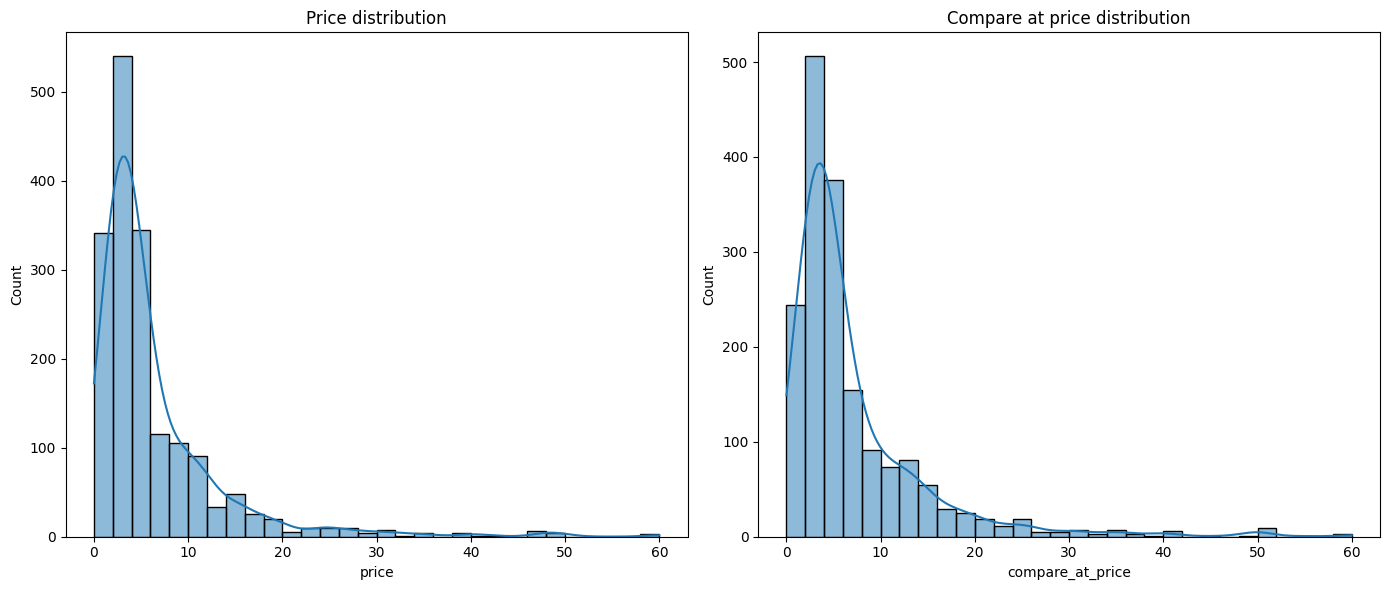

In [114]:
fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(14,6))
sns.histplot(inventory_df['price'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Price distribution')

sns.histplot(inventory_df['compare_at_price'].dropna(), bins=30, kde=True, ax=axes[1])
axes[1].set_title('Compare at price distribution')

plt.tight_layout()
plt.show()

In [115]:
top_vendors=inventory_with_price_df['vendor'].value_counts().reset_index()
top_vendors.columns=['vendor', 'count']
top_vendors.head(15)

,vendor,count
0,biona,58
1,ecover,34
2,faithinnature,27
3,method,26
4,hiderfoods,24
5,greencuisine,24
6,various,23
7,napolina,19
8,ellaskitchen,18
9,febreze,17


In [116]:
top_products=inventory_with_price_df['product_type'].value_counts().reset_index()
top_products.columns=['product_type', 'count']
top_products.head(15)

,product_type,count
0,cleaning-products,154
1,tins-packaged-foods,112
2,snacks-confectionery,110
3,cooking-ingredients,73
4,pasta-rice-noodles,64
5,baby-toddler-food,62
6,condiments-dressings,52
7,haircare,50
8,cereal,49
9,soft-drinks-mixers,48


In [117]:
all_tags = inventory_with_price_df['tags'].explode()
tag_frequency = all_tags.value_counts().reset_index()
tag_frequency.columns = ['tag', 'count']
tag_frequency.head(10)

,tag,count
0,vegan,673
1,gluten-free,299
2,eco,285
3,cruelty-free,208
4,organic,170
5,b-corp,144
6,discontinue,114
7,christmas,108
8,refills,101
9,pm,68


These are the core of our inventory (in quantity), maybe not in sells and revenue

### Insights

* Our main providers are biona, ecover and faithinnature

* The top3 categories with the largest number of products available are cleaning-products, tins-packaged-foods and snacks-confectionery

* Our stock is very focused in healthy and sustainable products (vegan, gluten-free, eco, cruelty-free, organic...)

## Problems & Rework

* It would be interesting to do an analysis of the orders to check if also these products are the core of our revenue (for example long-life-milk-substitutes product-type doesn't have as many products availbable as other  product types but the best seller is of this category, so it would have an enormous impact in out revenue)

# ***Users data***

* Top Up vs Proposition clients

* Region users (user_nuts1) distribution

* User registration evolution (customer_cohort_month)

In [118]:
users_path = '/home/alex/zriveAM/zrive-ds/aws/data/users.parquet'
users_df = pd.read_parquet(users_path)
users_df.head(25)

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a962aa3d39097d41d37b01d5089f13306c248e66a110da986a44448c007ce8e1052db8d1802f00fbd85,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f65f3d519b46bc97b938812e4cea840a67b82c9ff349f086af76b5ba8171c0866103b942061d74027b1,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b93249db254a5f358ed7c17e47bebe76903b28447ece00be7e266aad036337cdf46ccdd9ab485136d40b85d,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN
675,57ca7591dc79825df0cecc4836a58e6062454555c86c354dd736bd34eca7eb4e588c5afea0af0bf3ee41290630bcdc6042b6fae0c19428d887b586a719825bda,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec007b214d1039e959eca61c2b5bd6dc5cc09b8147f3581366413cf9ca901906969ba6c152e44ab4cd8fb1,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
2203,ce6ca649c21f4eec31ed7489f74743e4fc756c0805c3f84ad330d2b0b762b861f014decf00e8c6b1422dbcef9f1845d54eaacda965c5b7d07e97fab58e15c219,Proposition,UKH,2020-12-21 10:33:30,2020-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN
49,f4b1822b86f82de690b19c87bf125a6bb8ff6b45a894cb2b500b5e9c48bbfe3e9719197ad6ad1bfcd07fe94ed4e06913e0b96cd58da2d21051812e8dab4debab,Top Up,UKJ,2021-04-13 11:05:11,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4007,605864ba5462c30b9ce789b768980fc0cac7fcfea0a43fb886137c7cb951dff84a1c92c28339447a3b1c47893912b65acc303ce8c4a55bf339636a5a0b85b9d8,Top Up,UKH,2021-08-31 16:07:45,2021-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN
3563,bd55f50eb43f2052212c6ed171d67c094f44644b79625e78ebf19295bb9df721b2e6e3510a1be655ed013693c3f59b4e892589a215de4b2f2a8900c84c607812,Top Up,UKH,2020-12-30 15:52:36,2020-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN
358,78e1666879833f5c2d815c19aa7c19cddbc89da4917473ab4a31530ff397fce0c6da6ecc23a1d89c0bfa1389ce779e4f8e10f2cad4e7c29ad2bdf853a1e6ec53,Top Up,UKI,2020-11-19 10:12:07,2020-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


Este dataframe es el que más variables incluye :

* user_id: id del cliente

* user_segment: algún tipo de distintivo de clientes (top up y proposition)

* user_nuts1: region de uk (UKH - East of England, UKD - North West England, etc)

* first _ordered_at: Fecha exacta primer pedido (día, mes y año)

* customer_cohort_month: Mes y año de primer pedido (se puede utilizar para analizar la retención)

* count_people: numero de personas asociadas al id

* count_adults: numero de adultos asociados al id

* count_children: numero de niños asociados al id

* count_babies: numero de bebés asociados al id

* count_pets: numero de mascotas asociados al id

In [119]:
print("Dataframe info:")
print(users_df.info())
print("----------------------------------")
print("Null values:")
print(users_df.isnull().sum())


Dataframe info:
<class 'pandas.core.frame.DataFrame'>
Index: 4983 entries, 2160 to 3360
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                4983 non-null   object 
 1   user_segment           4983 non-null   object 
 2   user_nuts1             4932 non-null   object 
 3   first_ordered_at       4983 non-null   object 
 4   customer_cohort_month  4983 non-null   object 
 5   count_people           325 non-null    float64
 6   count_adults           325 non-null    float64
 7   count_children         325 non-null    float64
 8   count_babies           325 non-null    float64
 9   count_pets             325 non-null    float64
dtypes: float64(5), object(5)
memory usage: 428.2+ KB
None
----------------------------------
Null values:
user_id                     0
user_segment                0
user_nuts1                 51
first_ordered_at            0
customer_cohort_month       

In [120]:
#Unique clients
unique_clients=orders_df['user_id'].value_counts()
print(len(unique_clients))

4983


According to orders info, we had 4893 user_ids, and according to this dataset we have also 4983, so in this case all users_id are registered

user_segment
Top Up         2643
Proposition    2340
Name: count, dtype: int64


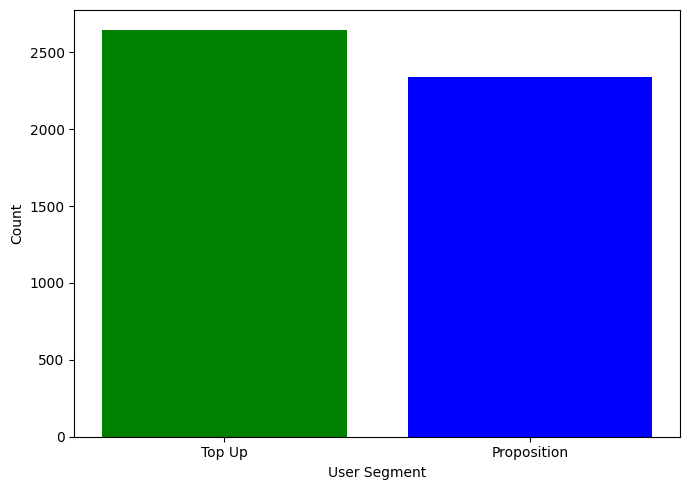

In [121]:
user_segment=users_df['user_segment'].value_counts()
print(user_segment)

plt.figure(figsize=(7,5))
plt.bar(user_segment.index, user_segment.values, color=['green', 'blue'])
plt.xlabel('User Segment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


However, in the first analysis I separated betwwen users with 1 order and > than 1 order

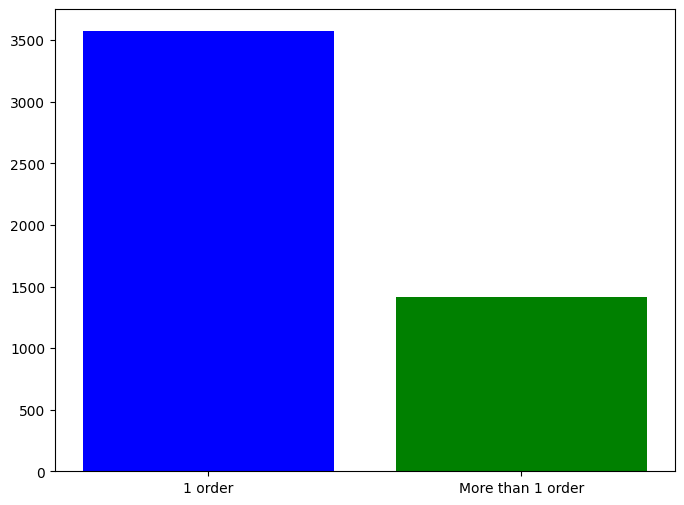

Categories top up and proposition appear to be unrelated to categories 1 order and > 1 order 

user_nuts1
UKI    1318
UKJ     745
UKK     602
UKH     414
UKD     358
UKM     315
UKE     303
UKG     295
UKF     252
UKL     224
UKC     102
UKN       4
Name: count, dtype: int64


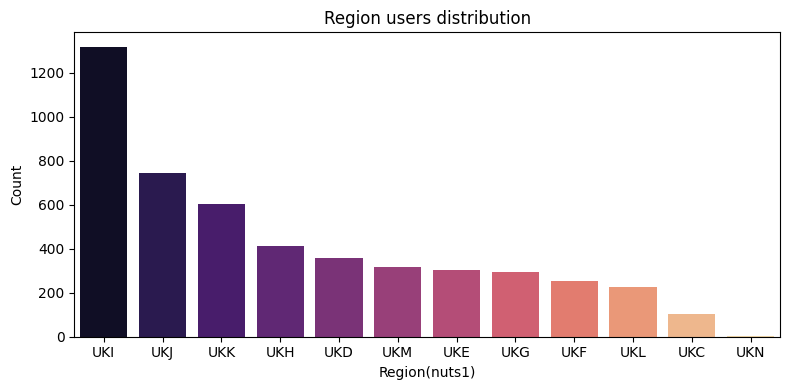

In [122]:
user_nuts1=users_df['user_nuts1'].value_counts()
print(user_nuts1)

plt.figure(figsize=(8,4))
sns.barplot(x=user_nuts1.index, y=user_nuts1.values, hue=user_nuts1.index, legend=False, palette='magma')
plt.title('Region users distribution')
plt.xlabel('Region(nuts1)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

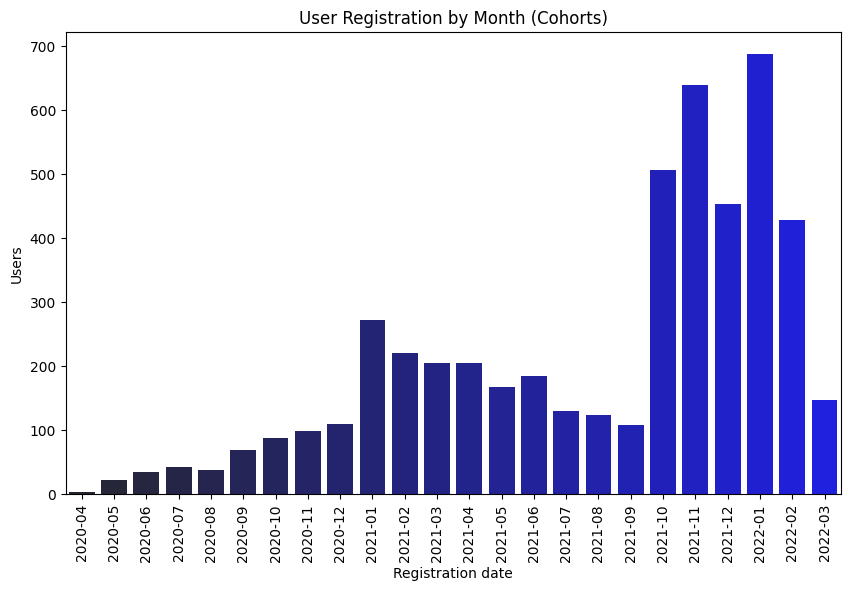

In [123]:
users_df['cohort_month'] = pd.to_datetime(users_df['customer_cohort_month']).dt.to_period('M')


cohort_counts = users_df['cohort_month'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=cohort_counts.index, y=cohort_counts.values, hue=cohort_counts.index, legend=False, palette='dark:blue')
#cohort_counts.plot(kind='bar', color='skyblue')
plt.title('User Registration by Month (Cohorts)')
plt.xlabel('Registration date')
plt.ylabel('Users')
plt.xticks(rotation=90)
plt.show()

This is very similar to the sales evolution

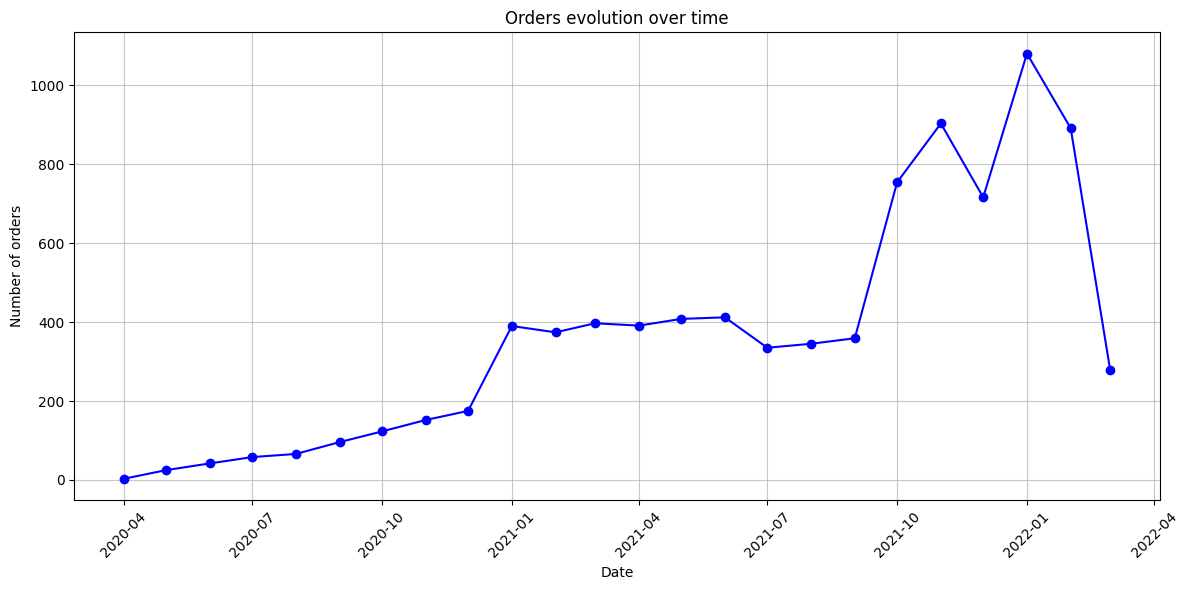

In [124]:
print(users_df.isnull().sum())

user_id                     0
user_segment                0
user_nuts1                 51
first_ordered_at            0
customer_cohort_month       0
count_people             4658
count_adults             4658
count_children           4658
count_babies             4658
count_pets               4658
cohort_month                0
dtype: int64


Here obviously we have a problem, because count_people = NaN is impossible and count_people=0 is neither an option because count_people=1 exists and means that it is an individual account.

The amount of NaN could suggest that it isn't mandatory to our clients to complete this information. It would be interesting to check the evolution of NaN of this category along the time.  maybe is a feature included recently and that explain why are so many users without whis information.

If there is no solution, I think these columns should be deleted and analyze the distributions of adults, children, babies and pets with the users that included this info.

Another minor problem is the 51 missing values in user_nuts1

In [125]:
users_df = pd.read_parquet(users_path)  # Reemplaza con el nombre real del archivo
users_df['customer_cohort_month']=pd.to_datetime(users_df['customer_cohort_month'])
users_df.sort_values(by='customer_cohort_month', inplace=True)
users_df.head(7)

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
3510,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700573ca76f11b45151d67944f171a88fd4f860f06d662c7b29d7b91f0dbc8bf14d410a169a0ed531040b,Top Up,UKF,2020-04-30 18:12:30,2020-04-01,4.0,2.0,2.0,0.0,1.0
1860,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f545e06fba241f377a0fbf04b5efe8607e8faf52f58ad39dc6a1b66ebca64a6747002ba543652cbc664d,Proposition,UKM,2020-04-30 17:39:00,2020-04-01,4.0,2.0,2.0,0.0,1.0
2475,62e271062eb827e411bd73941178d29b022f5f2de9d37f50190a1d6741e02be71414684ca6df992c186522a0433f10367d18d7102da301989cb7929559747eda,Proposition,UKI,2020-04-30 14:32:19,2020-04-01,4.0,4.0,0.0,0.0,0.0
3083,0074992079c1836c6509eec748a973dc97388b4877e770f57a3dc05917641897fd65ed9ab35168ce32f7c428c3e048206e12a653f40d48d7eb7db3570b4521b4,Proposition,UKI,2020-05-18 21:37:52,2020-05-01,4.0,2.0,2.0,0.0,0.0
2872,1296e1e72f7f43ff28d7d285f880ad4d213fa8139233c78ad2673af4cc0c1c297180254da494cc3b934858347822be437eeb072acb1403e9476dc0b2f6a83cbe,Proposition,UKJ,2020-05-20 16:04:59,2020-05-01,NaN,NaN,NaN,NaN,NaN
245,dae0ada010ff9ac559172ee1c784e77d6b12a72b1df604ea503a514194edd94d88dd52195b74ef36b445aff40d1173a025a8955cd3593d577b6ef80433264edc,Proposition,UKK,2020-05-09 14:11:59,2020-05-01,NaN,NaN,NaN,NaN,NaN
1501,2d20842e0b680c1143a4daaabffd6c7b018b2fe4062a70d75356d4a141faffffe5f90324ad9af3d975d4ff58baa46e95d132142203e7c67484f36965e3d9f52e,Proposition,UKK,2020-05-11 19:04:39,2020-05-01,3.0,2.0,0.0,1.0,0.0


This discards the hypothesis that the option to specify the people associated to the account was included recently, the first users had the option and it was optional, of the first 7 clients, 5 indicated this information and 2 didn't

## Insights

* There exist 2 user_segment categories (Top Up and Proposition), almost equal distributed

* information abount adults, children, babies and pets associated to each account is optional and only 6.5 % (325 of 4983 accounts) include this info

* Customer_cohort_month is strongly related to the number of orders along the months, this is something negative, our orders strongly depend of new users (better depend of recurrent clients)

### Problems & rework

Decide what to do with count_ values

# ***Homework part 2***

# ***Feature frame dataset***

In [126]:
feature_frame_path = '/home/alex/zriveAM/zrive-ds/aws/data/feature_frame.csv'
feature_frame_df = pd.read_csv(feature_frame_path)

In [127]:
feature_frame_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [128]:
print('Dataframe info:')
print(feature_frame_df.info())

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults        

In [129]:
print("Null values:")
print(feature_frame_df.isnull().sum())

Null values:
variant_id                          0
product_type                        0
order_id                            0
user_id                             0
created_at                          0
order_date                          0
user_order_seq                      0
outcome                             0
ordered_before                      0
abandoned_before                    0
active_snoozed                      0
set_as_regular                      0
normalised_price                    0
discount_pct                        0
vendor                              0
global_popularity                   0
count_adults                        0
count_children                      0
count_babies                        0
count_pets                          0
people_ex_baby                      0
days_since_purchase_variant_id      0
avg_days_to_buy_variant_id          0
std_days_to_buy_variant_id          0
days_since_purchase_product_type    0
avg_days_to_buy_product_type        0

Although there are no null values, there are values=0 that are missing values

outcome
0.0    0.988463
1.0    0.011537
Name: proportion, dtype: float64


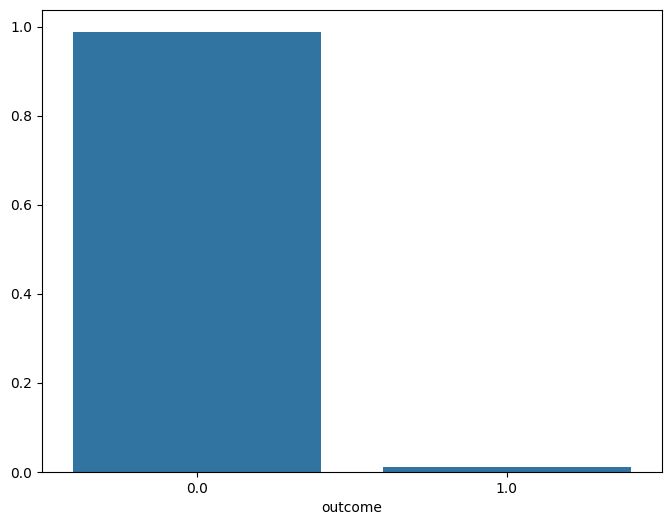

In [130]:
# Distribution of outcome
outcome_dist = feature_frame_df['outcome'].value_counts(normalize=True)
print(outcome_dist)

plt.figure(figsize=(8,6))
sns.barplot(x=outcome_dist.index, y= outcome_dist.values)
plt.show()

There are different types of columns, we can group them to do a better analysis

In [131]:
feature_frame_df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at', 'order_date', 'user_order_seq', 'outcome', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular', 'normalised_price',
       'discount_pct', 'vendor', 'global_popularity', 'count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id', 'avg_days_to_buy_variant_id',
       'std_days_to_buy_variant_id', 'days_since_purchase_product_type', 'avg_days_to_buy_product_type', 'std_days_to_buy_product_type'],
      dtype='object')

In [132]:
info_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
label_col = "outcome"
features_cols = [col for col in feature_frame_df.columns if col not in info_cols + [label_col]]

categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]


In [133]:
for col in binary_cols:
    print(f"Value counts {col}: {feature_frame_df[col].value_counts().to_dict()}")
    print(f"Mean outcome by {col} value: {feature_frame_df.groupby(col)[label_col].mean().to_dict()}")
    print(" ------------ ")

Value counts ordered_before: {0.0: 2819658, 1.0: 60891}
Mean outcome by ordered_before value: {0.0: 0.008223337723936732, 1.0: 0.1649669080816541}
 ------------ 
Value counts abandoned_before: {0.0: 2878794, 1.0: 1755}
Mean outcome by abandoned_before value: {0.0: 0.011106039542947498, 1.0: 0.717948717948718}
 ------------ 
Value counts active_snoozed: {0.0: 2873952, 1.0: 6597}
Mean outcome by active_snoozed value: {0.0: 0.011302554809544488, 1.0: 0.1135364559648325}
 ------------ 
Value counts set_as_regular: {0.0: 2870093, 1.0: 10456}
Mean outcome by set_as_regular value: {0.0: 0.010668992259135854, 1.0: 0.24971308339709258}
 ------------ 


Las features que nos indican si el usuario había interactuado con el producto antes (ordered, abandoned, snoozed, set_as_regular) estan muy desbalanceadas. Algunas como snooze o abandoned son muy extremas, quizas prodrían eliminarse o crear una meta feaure que represente si el usuario ha interactuado con el producto antes ( si cualquiera de las features anteriores es 1, meta feature es 1, si todas son 0, meta feature es 0)

These binary variables are strongly related with `outcome`.

Specifically, abandoned_before. If an item had not been abandoned before, it will only be purchased 1.11% of the time.

However, if an item had been abandoned before, it will be purchased 71.8 % of the time in a future order.

<Axes: >

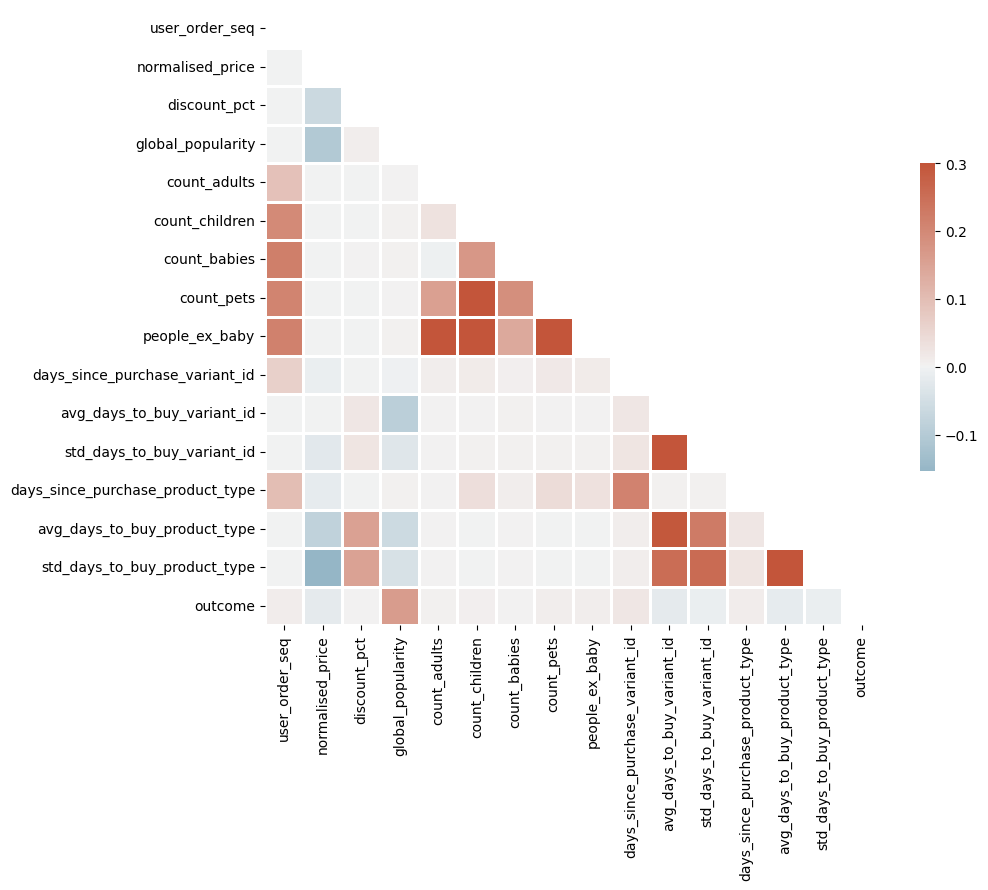

In [134]:
#Correlation matrix

corr = feature_frame_df[numerical_cols + [label_col]].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10,8))

cmap = sns.diverging_palette(230,20, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink":0.5},
)

- Check correlations between variables

- Check correlations with outcome

Algunas variables númericas están moderadamente correladas. Algo a tener en cuenta si utilizamos modelos donde la colinearidad pueda ser importante.

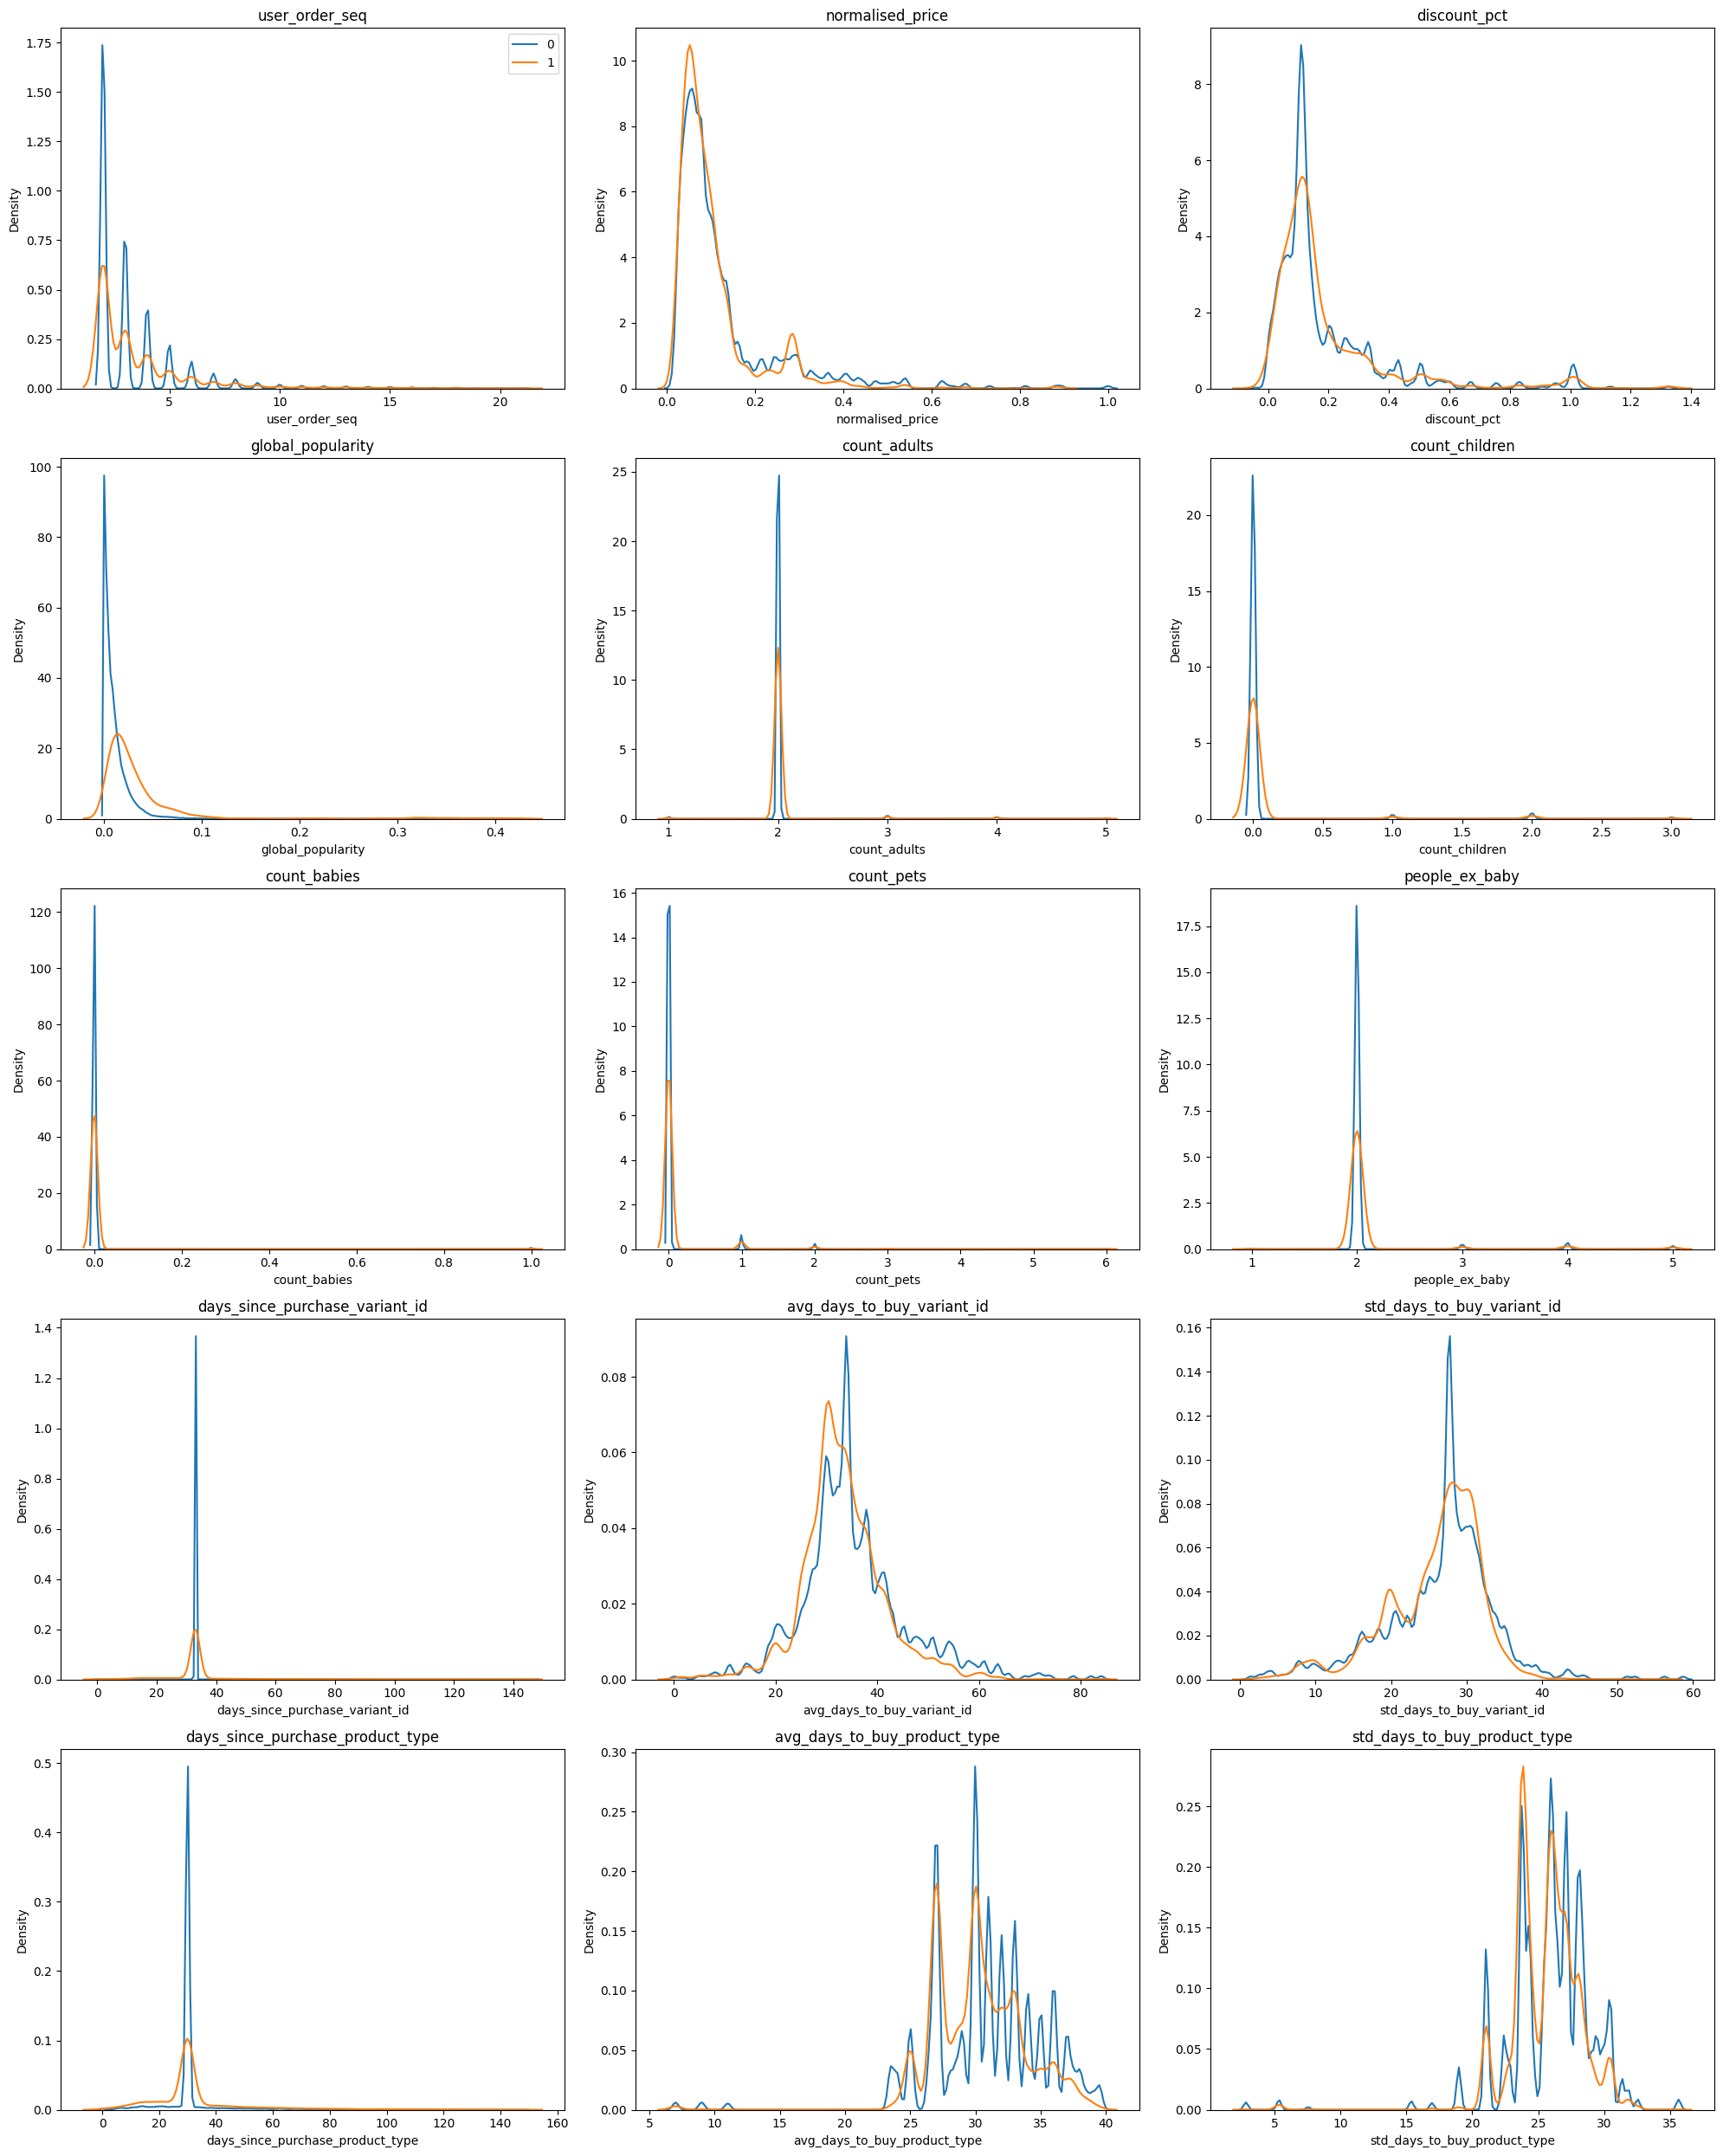

In [135]:
cols = 3
rows = int(np.ceil(len(numerical_cols) / cols))
fig, ax = plt.subplots(rows, cols, figsize=(20, 5 * rows))
ax = ax.flatten()

for i, col in enumerate(numerical_cols):
    sns.kdeplot(feature_frame_df.loc[lambda x: x.outcome == 0, col], label="0", ax=ax[i])
    sns.kdeplot(feature_frame_df.loc[lambda x: x.outcome == 1, col], label="1", ax=ax[i])
    ax[i].set_title(col)

ax[0].legend()
plt.tight_layout()



En este caso representamos las distribuciones para las dos clases (outcome 0 y outcome 1) de forma separada.
Saber si la distribución es distinta para cada una de las clases es muy informativo. 

* En global_popularity, cuando outcome=1, la popularidad de los productos es mas alta (cuando la popularidad es las alta, la probabilidad de que se compre es mas alta)

* Las variables de count_ siguen un patron extraño, ya que tienen unos picos extremadamente altos, esto se debe a que los missing values de estas variables se han imputado (ya sea con la media, mediana, freq...), esto lo que hace es que perdamos info, ya que quizas los usuarios que tenian esta info estaban muy correlados con outcome=1, se deberia haber añadido una columna que indique si el valor se ha imputado o no. Sin embargo, si aumenta el poder predictivo, es una buena imputacion, a pesar de la distribucion

In [136]:
feature_frame_df[categorical_cols].describe()

,product_type,vendor
count,2880549,2880549
unique,62,264
top,tinspackagedfoods,biona
freq,226474,146828


Tienen muchas categorias, por lo que categorical enconding empezaria por frequency encoding o algo que no aumente el numero de columnas en 62 o 264.

Es cierto, que la mejor forma de hacer coding de las variables categoricas es aquella que mejore el poder predictivo de mi modelo, por eso en el siguiente modulo se ve como crear un pipeline de entrenamiento que optimice las decisiones.